### ResNe50 을 이용한 식재료 이미지 객체 탐지

In [2]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.8 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=ac97703acc0c8648adad30d0bd7bde921da0d1f2a16d7e18fb7f0f69073a76a5
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: idna
    Found e

### 데이터 다운로드
Roboflow  : <a href='https://universe.roboflow.com/onmk0428-naver-com/food-dlp59/dataset/2'>food-dlp59</a>

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="8Zv6K9jnOf2w4tz7CTlg")
project = rf.workspace("onmk0428-naver-com").project("food-dlp59")
dataset = project.version(2).download("multiclass")


loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to food-2 in multiclass:: 100%|██████████| 12346/12346 [00:04<00:00, 3034.67it/s]


### 데이터 확인

In [4]:
import os

train_path = '/content/food-2/train'
valid_path = '/content/food-2/valid'

train_fnames = os.listdir(train_path)
valid_fnames = os.listdir(valid_path)

class_file = [fname for fname in train_fnames if '.csv' in fname ]
class_file # class 파일
print(len(train_fnames))
print(len(valid_fnames))

9841
2501


In [5]:
import pandas as pd

#### class.csv 파일 확인

In [6]:
train_class = pd.read_csv(train_path+'/_classes.csv')
valid_class = pd.read_csv(valid_path+'/_classes.csv')

train_class.tail()

,filename,Apple,Banana,Broccoli,Cabbage,Cantaloupe,Carrot,Cucumber,Egg,Grape,Lemon,Mango,Mushroom,Orange,Peach,Pear,Pineapple,Potato,Pumpkin,Tomato
9835,50f3c620a163d796_jpg.rf.fffcf1b940b1ec25729266...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9836,0935a4b02465512b_jpg.rf.ff5be46f6eabe8768693e1...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
9837,0432875b5ec6bfb0_jpg.rf.fff4c3d2d2eb5d00ef7208...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9838,96ddbb92f308e6f6_jpg.rf.ffaefb3f91415c7d5e1681...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9839,ede79ee6797675e6_jpg.rf.ffe4fa2ca731845fcd5b6b...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


식재료 이미지 종류

- Apple
- Banana
-	Cabbage
-Cantaloupe
- Carrot
- Cucumber
- Egg
- Grape
- Lemon
- Mango
- Mushroom
- Orange
- Peach
- Pear
- Pineapple
- Potato
- Pumpkin
- Tomato

In [7]:
# label 확인
print(train_class.columns)
print(valid_class.columns)

Index(['filename', ' Apple', ' Banana', ' Broccoli', ' Cabbage', ' Cantaloupe',
       ' Carrot', ' Cucumber', ' Egg', ' Grape', ' Lemon', ' Mango',
       ' Mushroom', ' Orange', ' Peach', ' Pear', ' Pineapple', ' Potato',
       ' Pumpkin', ' Tomato'],
      dtype='object')
Index(['filename', ' Apple', ' Banana', ' Broccoli', ' Cabbage', ' Cantaloupe',
       ' Carrot', ' Cucumber', ' Egg', ' Grape', ' Lemon', ' Mango',
       ' Mushroom', ' Orange', ' Peach', ' Pear', ' Pineapple', ' Potato',
       ' Pumpkin', ' Tomato'],
      dtype='object')


### 데이터 전처리
ResNet 모델에 사용할 수 있도록 데이터 전처리

- class.csv 파일에 담긴 레이블 정보를 이용해 jpg 파일 별 식재료 폴더를 생성   

In [8]:
train_label_mapping = {}
valid_label_mapping = {}
# filename 과 값이 1 label 매핑
for _, row in train_class.iterrows():
    filename = row['filename']
    labels = [label.strip()  for label, value in row.items() if label != 'filename' and value == 1]
    train_label_mapping[filename] = labels

for _, row in valid_class.iterrows():
    filename = row['filename']
    labels = [label.strip()  for label, value in row.items() if label != 'filename' and value == 1]
    valid_label_mapping[filename] = labels


In [9]:
# file 이름과 식재료 매핑

import shutil

# dataset 파일 생성
base_dir = './dataset'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'val')
os.mkdir(validation_dir)

labels = map(str.strip, valid_class.columns.values)
labels = [lable for lable in labels if lable != 'filename' ]

# 식재료 label 별 폴더 생성
for cls in labels:
  os.mkdir(os.path.join(train_dir, cls))
  os.mkdir(os.path.join(validation_dir, cls))

# lable 폴더별 이미지 파일 복사
for filename in train_fnames:
  src = os.path.join(train_path, filename) # 복사되는 파일 주소
  if '_classes.csv' not in src:  # Exclude the '_classes.csv' file
    dst = os.path.join(os.path.join(train_dir, train_label_mapping[filename][0]), filename) # 복사한 파일이 저장되는 주소
    shutil.copyfile(src, dst)


for filename in valid_fnames:
  src = os.path.join(valid_path, filename) # 복사되는 파일 주소
  if '_classes.csv' not in src:  # Exclude the '_classes.csv' file
    dst = os.path.join(os.path.join(validation_dir, valid_label_mapping[filename][0]), filename) # 복사한 파일이 저장되는 주소
    shutil.copyfile(src, dst)



#### 식재료 폴더별 데이터 확인

In [10]:
labels = os.listdir(train_dir) # 식재료 폴더 리스트
print("count of labels: {}".format(len(labels)))
print("------------------------")

for label in labels:
    print("{}, {} files".format(label, len(os.listdir(os.path.join(train_dir,label)))))

count of labels: 19
------------------------
Cabbage, 224 files
Apple, 854 files
Pear, 191 files
Mushroom, 1392 files
Tomato, 921 files
Banana, 557 files
Egg, 750 files
Peach, 126 files
Grape, 594 files
Mango, 101 files
Cantaloupe, 79 files
Potato, 245 files
Orange, 532 files
Broccoli, 370 files
Cucumber, 338 files
Pumpkin, 1346 files
Lemon, 515 files
Carrot, 466 files
Pineapple, 239 files


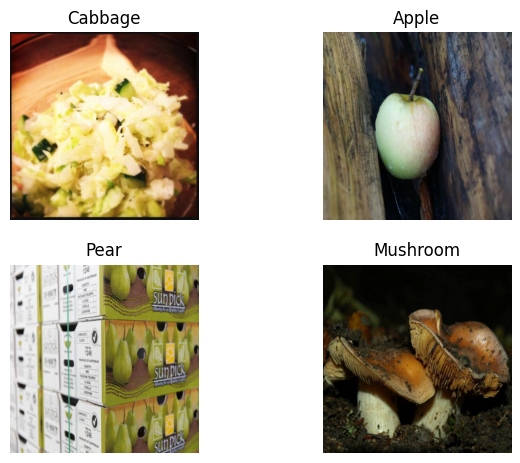

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()
cnt = 0
for row in ax:
    for col in row:
        image_name = np.random.choice(os.listdir( os.path.join(train_dir,labels[cnt])))
        im = Image.open("./dataset/train/{}/{}".format(labels[cnt],image_name))
        col.imshow(im)
        col.set_title(labels[cnt])
        col.axis('off')
        cnt += 1

# fig.suptitle('Train dataset')
plt.show()

In [12]:
!pip list | grep -e fastai -e torch -e torchvision

fastai                           2.7.12
torch                            2.0.1+cu118
torchaudio                       2.0.2+cu118
torchdata                        0.6.1
torchsummary                     1.5.1
torchtext                        0.15.2
torchvision                      0.15.2+cu118


### Pytorch with ResNet50

In [ ]:
import torch

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    r"""
    3x3 convolution with padding
    - in_planes: in_channels
    - out_channels: out_channels
    - bias=False: BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정.
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        r"""
         - inplanes: input channel size
         - planes: output channel size
         - groups, base_width: ResNext나 Wide ResNet의 경우 사용
        """
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        # Basic Block의 구조
        self.conv1 = conv3x3(inplanes, planes, stride)  # conv1에서 downsample
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # short connection
        if self.downsample is not None:
            identity = self.downsample(x)

        # identity mapping시 identity mapping후 ReLU를 적용합니다.
        # 그 이유는, ReLU를 통과하면 양의 값만 남기 때문에 Residual의 의미가 제대로 유지되지 않기 때문입니다.
        out += identity
        out = self.relu(out)

        return out

In [ ]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4 # 블록 내에서 차원을 증가시키는 3번째 conv layer에서의 확장계수

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # ResNext나 WideResNet의 경우 사용
        width = int(planes * (base_width / 64.)) * groups

        # Bottleneck Block의 구조
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation) # conv2에서 downsample
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        # 1x1 convolution layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 3x3 convolution layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        # 1x1 convolution layer
        out = self.conv3(out)
        out = self.bn3(out)
        # skip connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
# 기본 ResNet 50층
def resnet50(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)


In [ ]:
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    r"""
    - pretrained: pretrained된 모델 가중치를 불러오기 (saved by caffe)
    - arch: ResNet모델 이름
    - block: 어떤 block 형태 사용할지 ("Basic or Bottleneck")
    - layers: 해당 block이 몇번 사용되는지를 list형태로 넘겨주는 부분
    """
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        # default values
        self.inplanes = 64 # input feature map
        self.dilation = 1
        # stride를 dilation으로 대체할지 선택
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group

        r"""
        - 처음 입력에 적용되는 self.conv1과 self.bn1, self.relu는 모든 ResNet에서 동일
        - 3: 입력으로 RGB 이미지를 사용하기 때문에 convolution layer에 들어오는 input의 channel 수는 3
        """
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        r"""
        - 아래부터 block 형태와 갯수가 ResNet층마다 변화
        - self.layer1 ~ 4: 필터의 개수는 각 block들을 거치면서 증가(64->128->256->512)
        - self.avgpool: 모든 block을 거친 후에는 Adaptive AvgPool2d를 적용하여 (n, 512, 1, 1)의 텐서로
        - self.fc: 이후 fc layer를 연결
        """
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, # 여기서부터 downsampling적용
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        r"""
        convolution layer 생성 함수
        - block: block종류 지정
        - planes: feature map size (input shape)
        - blocks: layers[0]와 같이, 해당 블록이 몇개 생성돼야하는지, 블록의 갯수 (layer 반복해서 쌓는 개수)
        - stride와 dilate은 고정
        """
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1

        # the number of filters is doubled: self.inplanes와 planes 사이즈를 맞춰주기 위한 projection shortcut
        # the feature map size is halved: stride=2로 downsampling
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        # 블록 내 시작 layer, downsampling 필요
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion # inplanes 업데이트
        # 동일 블록 반복
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [68]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import os

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 128
epochs = 20

data_transforms = {
    "train": transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop(52),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.RandomCrop(52),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "./dataset"  # Replace this with the actual path to your dataset

full_dataset = ImageFolder(root=train_dir, transform=data_transforms["train"])

# Split full_dataset into train_dataset (80%) and validation_dataset (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, validation_dataset = random_split(full_dataset, [train_size, val_size])

# Create test_dataset using the "test" directory
test_dataset = ImageFolder(root=os.path.join(data_dir, "val"), transform=data_transforms["test"])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(validation_dataset),
    "test": len(test_dataset)
}

class_names = full_dataset.classes

for x in ["train", "val", "test"]:
    print(f"Number of samples in {x} dataset: {dataset_sizes[x]}")
print("Class names:", class_names)



Number of samples in train dataset: 7872
Number of samples in val dataset: 1968
Number of samples in test dataset: 2500
Class names: ['Apple', 'Banana', 'Broccoli', 'Cabbage', 'Cantaloupe', 'Carrot', 'Cucumber', 'Egg', 'Grape', 'Lemon', 'Mango', 'Mushroom', 'Orange', 'Peach', 'Pear', 'Pineapple', 'Potato', 'Pumpkin', 'Tomato']


In [69]:
from torchvision import models
#  ImageNet 데이터셋으로 학습된 가중치를 사용
resnet = models.resnet50(pretrained = True)
# ResNet50 모델의 마지막 fully connected(fc) 레이어의 입력 채널 수를 가져와 입력 차원 결정
num_ftrs = resnet.fc.in_features
# 모델은 19개의 클래스(식재료 종류)를 구분하는 다중 클래스 분류기로 변환됩니다.
resnet.fc = nn.Linear(num_ftrs, 19)
resnet = resnet.to(device)

# 다중 클래스 분류 문제를 해결하기 위해 교차 엔트로피 손실 함수를 사용
criterion = nn.CrossEntropyLoss()

# requires_grad=True인 파라미터들만 업데이트
optimizer_ft = optim.Adam(filter(lambda p : p.requires_grad, resnet.parameters()), lr=0.001)

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 5, gamma = 0.1)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


In [70]:
 # ResNet50 모델의 첫 5개 층을 제외하고 나머지 층들의 학습을 비활성화

ct = 0
for child in resnet.children():
  ct += 1
  if ct < 6:
    for param in child.parameters():
      param.requires_grad = False

In [71]:
def train_resnet(model, criterion, optimizer, scheduler, num_epochs = 25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range(num_epochs):
        print(f"---------- epoch {epoch + 1} ----------")
        since = time.time()

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    x, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)       # 교차엔트로피 계산 deafualt값이 mean이므로 각 데이터 마다의 손실 평균이 저장되있음
                                                                   # 한 배치 사이즈의 loss 총합을 계산!
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()
                l_r = [x["lr"] for x in optimizer_ft.param_groups]
                print("learning rate : ", l_r)

            epoch_loss = running_loss/dataset_sizes[phase]          # 전체 데이터 loss합을 각 데이터셋 전체 크기로 나눠주어 loss계산
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print("Completed in {:.0f}m {:0f}s".format(time_elapsed // 60, time_elapsed % 60))

    print("Best val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)

    return model

In [73]:
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler)
torch.save(model_resnet50, "resnet50_2.pt")

---------- epoch 1 ----------
learning rate :  [0.001]
train Loss: 2.306251 Acc: 0.5658
val Loss: 2.150400 Acc: 0.6179
Completed in 0m 58.613006s
---------- epoch 2 ----------
learning rate :  [0.001]
train Loss: 2.031240 Acc: 0.6449
val Loss: 2.046007 Acc: 0.6575
Completed in 0m 54.861094s
---------- epoch 3 ----------
learning rate :  [0.001]
train Loss: 1.834932 Acc: 0.6945
val Loss: 2.165711 Acc: 0.6479
Completed in 0m 52.325548s
---------- epoch 4 ----------
learning rate :  [0.001]
train Loss: 1.721863 Acc: 0.7287
val Loss: 2.087682 Acc: 0.6347
Completed in 0m 54.797749s
---------- epoch 5 ----------
learning rate :  [0.001]
train Loss: 1.590731 Acc: 0.7544
val Loss: 1.782699 Acc: 0.7195
Completed in 0m 52.080935s
---------- epoch 6 ----------
learning rate :  [0.001]
train Loss: 1.494665 Acc: 0.7890
val Loss: 1.830747 Acc: 0.7053
Completed in 0m 49.815072s
---------- epoch 7 ----------
learning rate :  [0.0001]
train Loss: 1.439430 Acc: 0.8025
val Loss: 1.854529 Acc: 0.7119
Comp

### 모델 평가

In [ ]:
def show_data(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pa

In [74]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.data.cpu().numpy())

    dataset_size = len(dataloader.dataset)
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    print("Test Loss: {:.4f} Test Accuracy: {:.4f}".format(epoch_loss, epoch_acc))

    return all_preds, all_labels



In [75]:
model = torch.load('./resnet50_2.pt')

preds, labels = evaluate_model(model, test_loader, criterion)


Test Loss: 1.3043 Test Accuracy: 0.6456


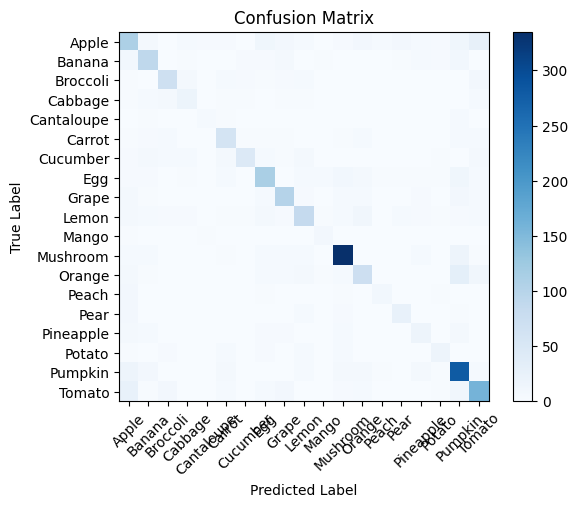

In [76]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Assuming 'all_preds' and 'all_labels' are lists containing predicted and ground truth labels, respectively
plot_confusion_matrix(labels, preds, class_names)


In [77]:
def imshow_with_labels(inputs, preds, labels, class_names, num_images=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        image = inputs[i].cpu().numpy().transpose((1, 2, 0))
        plt.imshow(image)
        plt.title(f"True Label: {class_names[labels[i]]}\nPredicted Label: {class_names[preds[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


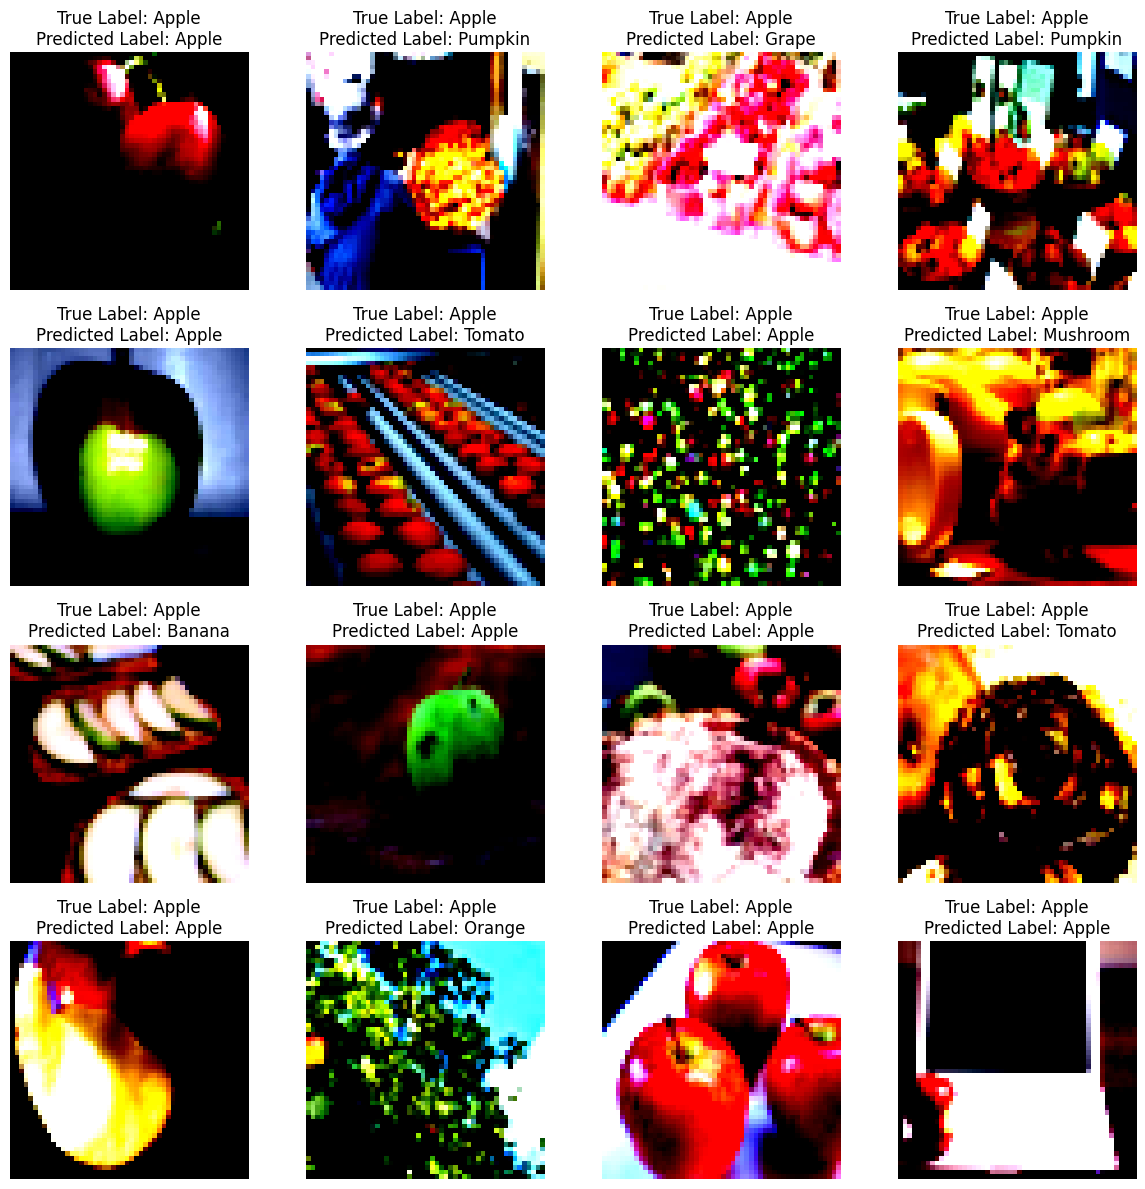

In [79]:
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
with torch.no_grad():
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

imshow_with_labels(inputs, preds, labels, class_names)
